In [1]:
import sys
import torch
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt

sys.path.insert(0, '../')
from lib.constants import *
from src.models import TransitionPredictor
from src.train import apply_masks

In [2]:
# Load saved tensors and phases
input_tensor, S_truth_tensor, phases = torch.load('../data/preprocessed/sample_0.pt',
                                                  weights_only=False)

S1_phase = torch.tensor(phases['S1_phase'])
S2_phase = torch.tensor(phases['S2_phase'])
S_truth_phase = torch.tensor(phases['S_truth_phase'])

In [3]:
# Load your trained model
model = TransitionPredictor()

# Load the model state_dict from the checkpoint
checkpoint_path = '../models/model_final.pth'
model.load_state_dict(torch.load(checkpoint_path))

# Set the model to evaluation mode
model.eval()

/var/folders/xg/wxxgtfvn18xd3w1f4y2cffkw0000gn/T/ipykernel_2891/3396318337.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_pa

TransitionPredictor(
  (conv_layers): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=16, bias=True)
  )
)

In [30]:
# Use the model to predict control signals for the transition
with torch.no_grad():
    control_signals = model(input_tensor.unsqueeze(0))

# Apply control signals to create the predicted mel-spectrogram using apply_masks
S1 = input_tensor[0]
S2 = input_tensor[1]
S_pred = apply_masks(S1, S2, control_signals[0], n_mels=S1.shape[0])

In [5]:
## WITHOUT PHASE ##

# # Convert S_pred to numpy array
# predicted_mel = S_pred.squeeze().detach().numpy()

# # Exponentiate the predicted mel-spectrogram since it was logged
# predicted_mel = np.exp(predicted_mel)

# # Reconstruct the audio using the Griffin-Lim algorithm
# reconstructed_audio = librosa.feature.inverse.mel_to_audio(predicted_mel, sr=SAMPLING_RATE,
#                                                            n_fft=N_FFT, hop_length=HOP_LENGTH)

In [14]:
## WITH PHASE ##

# Convert S_pred to numpy array
predicted_mel = S_pred.squeeze().detach().numpy()

# Exponentiate the predicted mel-spectrogram since it was logged
predicted_mel = np.exp(predicted_mel)

# Convert mel-spectrogram to STFT magnitude
predicted_stft = librosa.feature.inverse.mel_to_stft(predicted_mel, sr=SAMPLING_RATE, n_fft=N_FFT)

# Estimate the phase by averaging the phases of S1 and S2
# estimated_phase = (np.angle(S1_phase.numpy()) + np.angle(S2_phase.numpy())) / 2
estimated_phase = np.angle(S1_phase.numpy())

# Combine magnitude with estimated phase
stft_matrix = predicted_stft * np.exp(1j * estimated_phase)

# Reconstruct the audio using the Griffin-Lim algorithm
reconstructed_audio = librosa.griffinlim(np.abs(stft_matrix), n_iter=32, hop_length=HOP_LENGTH, win_length=N_FFT)

In [15]:
# Save the reconstructed audio
sf.write('reconstructed_audio_with_phase.wav', reconstructed_audio, SAMPLING_RATE)

In [31]:
control_signals = control_signals.squeeze().detach().numpy()

# Unpack volume parameters
S1_vol_start, S1_vol_slope, S2_vol_start, S2_vol_slope = control_signals[:4]

# Unpack band parameters
band_control_signals = control_signals[4:]
(S1_low_start, S1_low_slope,
 S1_mid_start, S1_mid_slope,
 S1_high_start, S1_high_slope,
 S2_low_start, S2_low_slope,
 S2_mid_start, S2_mid_slope,
 S2_high_start, S2_high_slope) = band_control_signals

# Define a time vector for plotting
time_vector = np.arange(input_tensor.shape[-1])

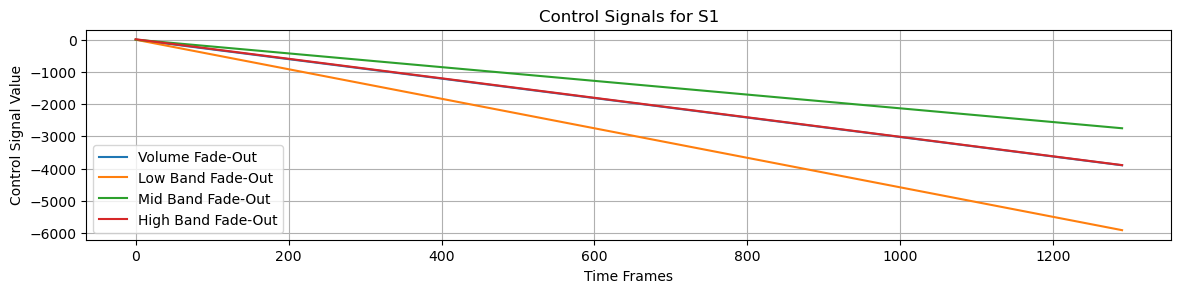

In [32]:
# Plot control signals for S1
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(time_vector, S1_vol_start + time_vector * S1_vol_slope, label='Volume Fade-Out')
plt.plot(time_vector, S1_low_start + time_vector * S1_low_slope, label='Low Band Fade-Out')
plt.plot(time_vector, S1_mid_start + time_vector * S1_mid_slope, label='Mid Band Fade-Out')
plt.plot(time_vector, S1_high_start + time_vector * S1_high_slope, label='High Band Fade-Out')
plt.xlabel('Time Frames')
plt.ylabel('Control Signal Value')
plt.title('Control Signals for S1')
plt.legend()
plt.grid(True)

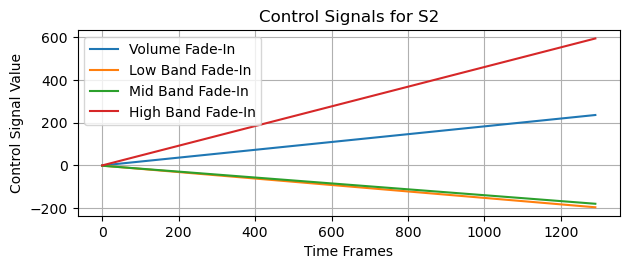

In [33]:
# Plot control signals for S2
plt.subplot(2, 1, 2)
plt.plot(time_vector, S2_vol_start + time_vector * S2_vol_slope, label='Volume Fade-In')
plt.plot(time_vector, S2_low_start + time_vector * S2_low_slope, label='Low Band Fade-In')
plt.plot(time_vector, S2_mid_start + time_vector * S2_mid_slope, label='Mid Band Fade-In')
plt.plot(time_vector, S2_high_start + time_vector * S2_high_slope, label='High Band Fade-In')
plt.xlabel('Time Frames')
plt.ylabel('Control Signal Value')
plt.title('Control Signals for S2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()